# Road Segmentation from Satellite Images - EPFL, AIcrowd

### Problem Statement:
For this problem, we provide a set of satellite/aerial images acquired from GoogleMaps. We also provide ground-truth images where each pixel is labeled as {road, background}. Your goal is to train a classifier to segment roads in these images, i.e. assign a label {road=1, background=0} to each pixel

### Dataset:
> 1. training.zip - the training set consisting of images with their ground truth
> 2. test_set_images.zip - the test set
> 3. sampleSubmission.csv - a sample submission file in the correct format
> 4. mask_to_submission.py - script to make a submission file from a binary image
> 5. submission_to_mask.py - script to reconstruct an image from the sample submission file

The sample submission file contains two columns:

1. The first column corresponds to the image id followed by the x and y top-left coordinate of the image patch (16x16 pixels)

2. The second column is the label assigned to the image patch



### Data Exploration

In [1]:
# 1. Number of images and annotations
import os
path2imgs = "training/images"
path2annots = "training/groundtruth"
imgsList = [i for i in os.listdir(path2imgs)]
anntsList = [i for i in os.listdir(path2annots)]

print("number of images: ", len(imgsList))0
print("number of annotations: ", len(anntsList))

In [2]:
# 2. Display few sample images and their masks
import numpy as np
np.random.seed(2021)
# selecting random images
rndImgs = np.random.choice(imgsList, 4)
rndImgs

array(['satImage_071.png', 'satImage_004.png', 'satImage_052.png',
       'satImage_076.png'], dtype='<U16')

In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


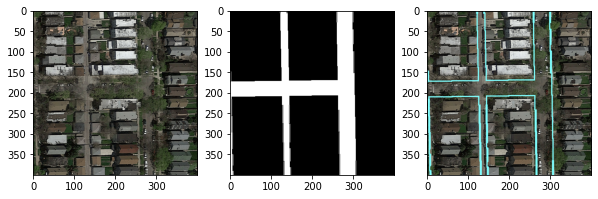

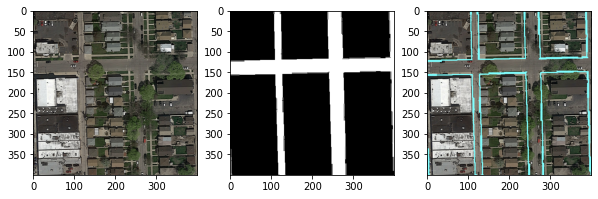

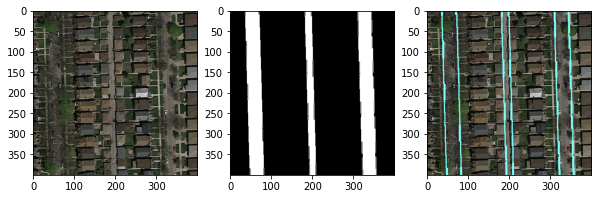

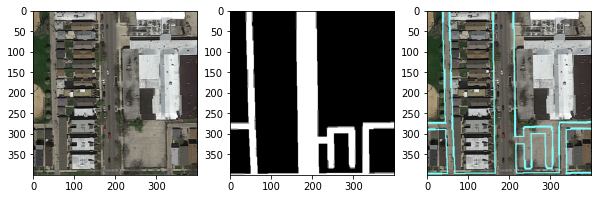

In [3]:
# Helper function to display image and annotations
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries # to overlay mask on the image
import torch 

def show_img_mask(img, mask):
    
    if torch.is_tensor(img):
        img = to_pil_image(img)
        mask = to_pil_image(mask)
    
    img_mask = mark_boundaries(np.array(img),
                             np.array(mask),
                             outline_color=(0.5,1,1),
                             color=(0.5,1,1))
    plt.imshow(img_mask)
    
# call the helper function to display
for i in rndImgs:
    path2img = os.path.join(path2imgs, i)
    path2annt = os.path.join(path2annots, i)
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    # converting edges to binary masks
    mask = ndi.binary_fill_holes(annt_edges) 
    
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    
    plt.subplot(1,3,3)
    show_img_mask(img, mask)

### Data Augmentation

In [4]:
# Install 'albumentations' package to augment the data for segmentation tasks

# 1. Install albumentations
!pip install albumentations

In [5]:
# 2. Import augmentation functions
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    Resize
)

# 3. transform train dataset
h, w = 128, 192
transform_train = Compose([Resize(h,w),
                          HorizontalFlip(p=0.5),
                          VerticalFlip(p=0.5),])

# 4. val dataset transformations
transform_val = Resize(h,w)

### Creating the datasets

In [6]:
# 1. Import required packages and define the dataset class

from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image

# Define the roadSeg_dataset class
class roadSeg_dataset(Dataset):
    def __init__(self, path2data, transform=None):
        '''
        self: pointer to class
        path2data: a string, location of data
        transform: the transformation function
        '''
        imgList = [i for i in os.listdir(path2imgs)]
        anntsList = [i for i in os.listdir(path2annots)]
        
        self.path2imgs = [os.path.join(path2imgs, i) for i in imgList]
        self.path2annts = [os.path.join(path2annots, i) for i in anntsList]
        self.transform = transform
        
    def __len__(self):
        ''' returns length of the dataset '''
        return len(self.path2imgs)
    
    def __getitem__(self, idx):
        ''' 
            function: loads the image and annotation files
            returns image and binary mask 
        '''
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)
        image = np.array(image)
        mask = mask.astype("uint8")
    
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # convert the array to PyTorch tensors
        image = to_tensor(image)
        # scale back mask values to the range of [0, 1]
        mask = 255*to_tensor(mask)
    
        return image, mask

In [7]:
# 2. Define two objects of roadSeg_dataset class
path2train = 'training'
roadSeg_ds1 = roadSeg_dataset(path2train, transform=transform_train)
roadSeg_ds2 = roadSeg_dataset(path2train, transform=transform_val)
print(len(roadSeg_ds1))
print(len(roadSeg_ds2))

100
100


torch.Size([3, 128, 192]) torch.FloatTensor tensor(0.9725)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


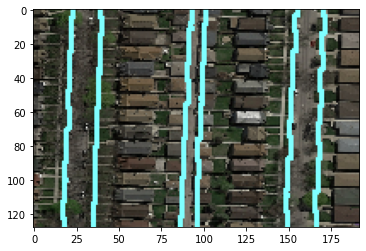

In [8]:
# 3. Fetch a sample image and mask from roadSeg_ds1
import torch
img,mask=roadSeg_ds1[0]
print(img.shape, img.type(),torch.max(img)) 
print(mask.shape, mask.type(),torch.max(mask))
show_img_mask(to_pil_image(img), to_pil_image(mask))

In [9]:
# 4. Split the dataset into tow groups
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices = range(len(roadSeg_ds1))

for train_index, val_index in ss.split(indices):
    print(len(train_index))
    print(" - # - "*5)
    print(len(val_index))

80
 - # -  - # -  - # -  - # -  - # - 
20


In [10]:
# 5. Create train_ds and val_ds
from torch.utils.data import Subset
train_ds = Subset(roadSeg_ds1, train_index)
val_ds = Subset(roadSeg_ds2, val_index)

print(len(train_ds))
print(len(val_ds))

80
20


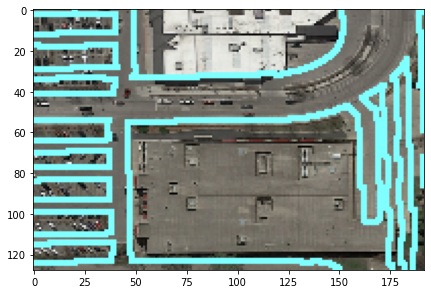

In [11]:
# 6. Sample image from train_ds and val_ds
plt.figure(figsize=(7,7))
for img, mask in train_ds:
    show_img_mask(img, mask)

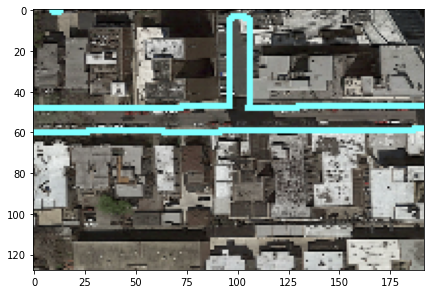

In [12]:
plt.figure(figsize=(7,7))
for img, mask in val_ds:
    show_img_mask(img, mask)

In [13]:
# 7. Define the data loaders
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

In [14]:
# 8. Sample batch from train_dl and val_dl

for img_b, mask_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

for img_b, mask_b in val_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 3, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 3, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


### Defining the model

In [15]:
# 1. Define the model class
import torch.nn as nn
import torch.nn.functional as F

# SegNet class
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs = params["num_outputs"]
        
        # Encoder - downsampling
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3, stride=1, padding=1)
        
        # Decoder - upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3, padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3, padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3, padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3, padding=1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
            
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
            
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
            
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
            
        x = F.relu(self.conv5(x))
            
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
            
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
            
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
            
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
            
        x = self.conv_out(x)
        return x

In [16]:
# 2. Define object of SegNet class
params_model = {
    "input_shape": (3, h, w),
    "initial_filters": 16,
    "num_outputs": 1,
}

model = SegNet(params_model)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

SegNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [18]:
# Model summary
from torchsummary import summary
summary(model, input_size=(3, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             448
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

### Define Loss Function

The BCE loss function compares each pixel of the prediction with that of the ground truth; however, we can combine multiple criteria to improve the overall performance of segmentation tasks. A popular technique is to combine the dice metric with the BCE loss. The dice metric is commonly used to test the performance of segmentation algorithms by calculating the amount of overlap between the ground truth and the prediction.

In [19]:
# 1. Helper function to calculate dice metric
def dice_loss(pred, target, smooth=1e-5):
    intersection = (pred*target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = 2.0*(intersection+smooth) / (union+smooth) # [0, 1]
    loss = 1.0-dice # dice loss
    return loss.sum(), dice.sum() # sum of loss values per data batch

In [20]:
# 2. Helper function to calculate combine loss per data batch
import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='sum')
    pred = torch.sigmoid(pred)
    div, _ = dice_loss(pred, target)
    loss = bce + div
    
    return loss

In [21]:
# 3. Helper function to compute metric per batch
def metrics_batch(pred, target):
    pred = torch.sigmoid(pred)
    _, metric = dice_loss(pred, target)
    return metric

In [22]:
# 4. Helper function to calculate loss and metric values per data batch
def loss_batch(loss_func, output, target, opt=None):
    '''
        loss_func: combined loss function in step 2
        output: predictions
        target: ground truth
        opt: optimizer
    '''
    loss = loss_func(output, target)
    with torch.no_grad():
        pred = torch.sigmoid(output)
        _, metric_b = dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

### Define the optimizer

In [23]:
# 1. Define the optimizer
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

# 2. Define the learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                patience=20, verbose=1)

# Helper function to get current learning rate value
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr = get_lr(opt)
print('current lr = {}'.format(current_lr))

current lr = 0.0003


### Training the model

This is an iterative process. <br>
In each iteration, we select a data batch from the training dataset. <br>
We then feed the data to the model to get the model output. <br>
Then, we calculate the loss value. <br>
Next, we compute the gradients of the loss function with respect to the model parameters (also known as weights). <br>
Finally, the optimizer updates the parameters based on the gradients, and this loop continues. <br>
We also use the validation dataset to monitor the model performance during training. <br>
We will stop the training process when the performance plateaus.

In [24]:
# 1. Define loss per each epoch helper function
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    '''
        model: an object of the model
        loss_func: an object of loss function
        dataset_dl: an object of data loader
        sanity_check: a boolean flag
        opt: an object of the optimizer
    '''
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb = xb.type(torch.float32).to(device)
        yb = yb.type(torch.float32).to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
            
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

In [25]:
# 2. Define training and validation helper function
import copy
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    loss_history={
        'train':[],
        'val':[]}
    
    metric_history={
        'train':[],
        'val':[]}
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, train_dl, sanity_check)
            
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print(" - # - "*10)
        
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [26]:
# 3. Train the model
path2models = "models/"
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler, 
    "path2weights": path2models+"weights.pt",

}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr = 0.0003
Copied best model weights!
train loss: 16686.137988, dice: 31.73
val loss: 15559.832422, dice: 30.25
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 1/99, current lr = 0.0003
Copied best model weights!
train loss: 14563.202148, dice: 24.91
val loss: 14230.144824, dice: 26.52
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 2/99, current lr = 0.0003
Copied best model weights!
train loss: 14150.035156, dice: 24.42
val loss: 14060.570312, dice: 24.75
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 3/99, current lr = 0.0003
Copied best model weights!
train loss: 14098.857422, dice: 24.72
val loss: 14032.530859, dice: 24.42
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 4/99, current lr = 0.0003
Copied best model weights!
train loss: 14079.945703, dice: 24.09
val loss: 14020.307617, dice: 25.04
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  -

Copied best model weights!
train loss: 11676.523730, dice: 37.80
val loss: 11382.480078, dice: 40.04
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 43/99, current lr = 0.0003
Copied best model weights!
train loss: 11268.954395, dice: 38.69
val loss: 11222.144336, dice: 40.29
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 44/99, current lr = 0.0003
Copied best model weights!
train loss: 11241.654004, dice: 39.17
val loss: 11131.051953, dice: 41.84
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 45/99, current lr = 0.0003
Copied best model weights!
train loss: 11144.279395, dice: 39.50
val loss: 11049.347363, dice: 42.53
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 46/99, current lr = 0.0003
train loss: 11030.279102, dice: 40.66
val loss: 11423.572266, dice: 40.57
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 47/99, current lr = 0.0003
tr

Copied best model weights!
train loss: 7808.283203, dice: 57.62
val loss: 7283.224658, dice: 56.80
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 86/99, current lr = 0.0003
Copied best model weights!
train loss: 7263.576611, dice: 58.73
val loss: 6998.541699, dice: 59.62
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 87/99, current lr = 0.0003
Copied best model weights!
train loss: 7133.853662, dice: 60.37
val loss: 6862.661377, dice: 61.45
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 88/99, current lr = 0.0003
Copied best model weights!
train loss: 6989.004297, dice: 60.16
val loss: 6660.312158, dice: 62.59
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 89/99, current lr = 0.0003
train loss: 6943.666260, dice: 61.34
val loss: 7155.089160, dice: 61.50
 - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # -  - # - 
Epoch 90/99, current lr = 0.0003
Copied best 

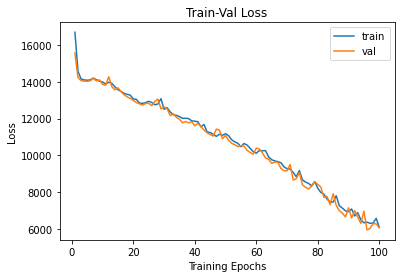

In [27]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

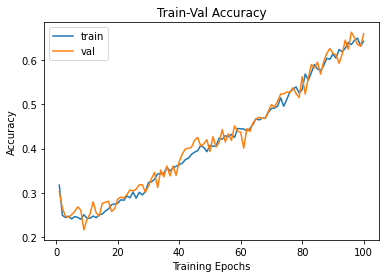

In [28]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()